In [1]:
#!/usr/bin/env python
# coding: utf-8

import os
import sys
sys.path.append('./')
sys.path.append('../')

import torch
import torchvision
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

/home/dinoboy22/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EPOCH = 100
BATCH_SIZE = 64
DEVICE = torch.device("cpu")

In [3]:
ROOT_DIR = '.' if os.path.exists('config') else '..' 
train_csv = os.path.join(ROOT_DIR, 'dataset', 'train.csv')
test_csv = os.path.join(ROOT_DIR, 'dataset', 'test.csv')

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_df = train_df.drop(['ID'],axis=1)
test_df = test_df.drop(['ID'],axis=1)

train_df = train_df.to_numpy()
test_df = test_df.to_numpy()

trainset = torch.tensor(train_df, dtype=torch.float64)
testset = torch.tensor(test_df, dtype=torch.float64)

In [4]:
class MyDataset(Dataset):
    # 해당 클래스는 torch.utils.data.Dataset을 상속받습니다.
    def __init__(self, data, target):
        super().__init__()
        # 해당 클래스의 인스턴스를 초기화합니다.
        self.data = data
        self.target = target

    def __len__(self):
        # 해당 데이터셋의 총 데이터 수를 리턴합니다.
        return len(self.data)
    
    def __getitem__(self, idx):
        # 인덱스 idx에 해당하는 데이터를 가져옵니다.
        return self.data[idx], self.target[idx]
    

if __name__ == "__main__":
    ROOT_DIR = '.' if os.path.exists('config') else '..' 
    train_csv = os.path.join(ROOT_DIR, 'dataset', 'train.csv')
    test_csv = os.path.join(ROOT_DIR, 'dataset', 'test.csv')
    
    train_df = pd.read_csv(train_csv)
    test_df = pd.read_csv(test_csv)

    train_df = train_df.drop(columns=['ID'],axis=1)
    test_df = test_df.drop(columns=['ID'],axis=1)

    # random_list = [1]
    # rand_iter = iter(random_list)
    # RANDOM_STATE = next(rand_iter)

    X_train, X_valid, y_train, y_valid = train_test_split(train_df.drop(columns=['y']), train_df['y'], test_size=0.2, shuffle=True, random_state=42)
    
    # train_df = train_df.drop(columns=['y','ID'],axis=1)
    # test_df = test_df.drop(columns=['ID'],axis=1)
    
    X_train = X_train.to_numpy()
    X_valid = X_valid.to_numpy()
    test_df = test_df.to_numpy()
    
    trainset = torch.tensor(X_train, dtype=torch.float64)
    validset = torch.tensor(X_valid, dtype=torch.float64)
    testset = torch.tensor(test_df, dtype=torch.float64)
    
    train_data = trainset
    train_target = trainset
    valid_data = validset
    valid_target = validset
    
    train_dataset = MyDataset(train_data, train_target)
    valid_dataset = MyDataset(valid_data, valid_target)

    train_Data, train_Target = train_dataset[0]

    print(len(train_dataset))
    print(train_Data.shape)
    print(train_Target)
    print(train_Data)

32094
torch.Size([11])
tensor([ 1.0040, -2.1228,  1.2432,  0.9364, -0.2562, -1.7881,  0.4648, -0.1479,
         0.6228,  0.3236,  0.0766], dtype=torch.float64)
tensor([ 1.0040, -2.1228,  1.2432,  0.9364, -0.2562, -1.7881,  0.4648, -0.1479,
         0.6228,  0.3236,  0.0766], dtype=torch.float64)


In [5]:
train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 4
)

In [6]:
valid_loader = DataLoader(
    dataset = valid_dataset,
    batch_size = len(valid_dataset),
    shuffle = True,
    num_workers = 4
)

In [7]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(11,8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            nn.Linear(8,5),
            nn.BatchNorm1d(num_features=5),
            nn.ReLU(),
            nn.Linear(5,3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3,5),
            nn.BatchNorm1d(num_features=5),
            nn.ReLU(),
            nn.Linear(5,8),
            nn.BatchNorm1d(num_features=8),
            nn.ReLU(),
            nn.Linear(8,11),
        )
        
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [8]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [9]:
def train(autoencoder, train_loader):
    autoencoder.train()
    losses = 0
    for batch_idx, (features, target) in enumerate(train_loader):
        target = target.to(DEVICE)
        features = features.float()
        logits = autoencoder(features)
        # print(type(logits))
        # print(logits)
        loss = criterion(logits[1],features)
        losses = losses + loss
        # print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses

In [10]:
def valid(autoencoder, valid_loader):
    autoencoder.eval()
    losses = 0
    for batch_idx, (features, target) in enumerate(valid_loader):
        target = target.to(DEVICE)
        features = features.float()
        logits = autoencoder(features)
        loss = criterion(logits[1],features)
        losses = losses + loss
    return losses

In [11]:
train_losses = []
valid_losses = []

In [12]:
patience = 5  
best_val_loss = float('inf')  
patience_counter = 0  

In [13]:
for epoch in range(1,EPOCH+1):
    train_loss = train(autoencoder, train_loader)
    # print(f'train loss = {torch.sqrt(train_loss)}')
    train_losses.append(train_loss.item())
    valid_loss = valid(autoencoder, train_loader)
    # print(f'valid loss = {torch.sqrt(valid_loss)}')
    valid_losses.append(valid_loss.item())
    #Early stopping
    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        patience_counter = 0  # 검증 손실이 개선되었으므로 patience_counter 초기화
    else:
        patience_counter += 1  # 검증 손실이 개선되지 않으면 patience_counter 증가

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

Early stopping at epoch 10


In [14]:
valid_losses

[2.904761791229248,
 0.7009668946266174,
 0.4494587182998657,
 0.3716065287590027,
 0.8957671523094177,
 0.5411717891693115,
 0.4674207270145416,
 0.46610227227211,
 0.6542373299598694]

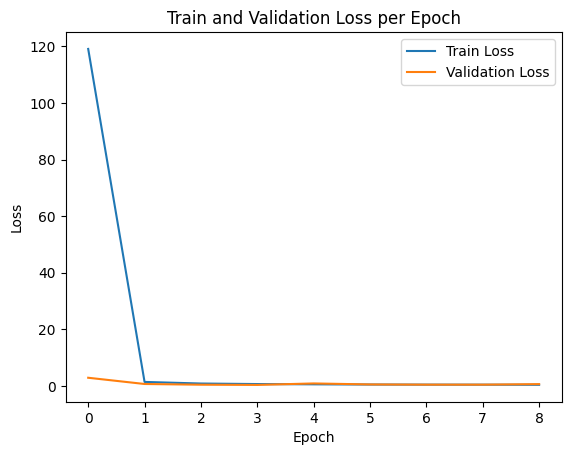

In [15]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss per Epoch')
plt.show()

In [16]:
def check_model_mode(model):
    if model.training:
        print("The model is in training mode.")
    else:
        print("The model is in evaluation mode.")

In [17]:
check_model_mode(autoencoder)

The model is in evaluation mode.


In [18]:
testset = testset.float()
result = autoencoder(testset)

In [19]:
loss_temp = nn.MSELoss()

In [20]:
for i in range(11):
    x0_output = torch.sqrt(loss_temp(testset[:,i], result[1][:,i]))
    print(x0_output)
    print(torch.std(testset[:,i]))
    print(f'{i}번째 feature-----------------------------------------')
    

tensor(0.0318, grad_fn=<SqrtBackward0>)
tensor(0.0532)
0번째 feature-----------------------------------------
tensor(0.0805, grad_fn=<SqrtBackward0>)
tensor(0.4677)
1번째 feature-----------------------------------------
tensor(0.0310, grad_fn=<SqrtBackward0>)
tensor(0.0460)
2번째 feature-----------------------------------------
tensor(0.0313, grad_fn=<SqrtBackward0>)
tensor(0.0512)
3번째 feature-----------------------------------------
tensor(0.0447, grad_fn=<SqrtBackward0>)
tensor(0.0854)
4번째 feature-----------------------------------------
tensor(0.0435, grad_fn=<SqrtBackward0>)
tensor(0.0787)
5번째 feature-----------------------------------------
tensor(0.0305, grad_fn=<SqrtBackward0>)
tensor(0.0266)
6번째 feature-----------------------------------------
tensor(0.0120, grad_fn=<SqrtBackward0>)
tensor(0.0498)
7번째 feature-----------------------------------------
tensor(0.0241, grad_fn=<SqrtBackward0>)
tensor(0.0436)
8번째 feature-----------------------------------------
tensor(0.0146, grad_fn=<Sqrt

In [21]:
encoder_only = autoencoder.encoder

In [22]:
class EncoderWithMLP(nn.Module):
    def __init__(self, encoder):
        super(EncoderWithMLP, self).__init__()
        self.encoder = encoder  # 기존 인코더를 사용
        self.mlp = nn.Sequential(
            nn.Linear(3, 2),
            nn.BatchNorm1d(num_features=2),
            nn.ReLU(),
            nn.Linear(2, 1)   
        )
    
    def forward(self, x):
        # 인코더를 통해 잠재 공간으로 압축
        encoded = self.encoder(x)
        # MLP를 통해 출력
        output = self.mlp(encoded)
        return output

In [23]:
encoder_with_mlp = EncoderWithMLP(encoder_only)

In [24]:
encoder_with_mlp.encoder.training

False

In [25]:
encoder_with_mlp.mlp.training

True

In [26]:
for param in encoder_with_mlp.encoder.parameters():
    param.requires_grad = False

In [27]:
optimizer = optim.Adam(encoder_with_mlp.mlp.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [28]:
encoder_mlp_train_df = train_df.drop(columns=['y'],axis=1)
encoder_mlp_train_df = encoder_mlp_train_df.to_numpy()
encoder_mlp_train_df = torch.tensor(encoder_mlp_train_df, dtype=torch.float64)
encoder_mlp_train_df = encoder_mlp_train_df.float()

In [29]:
y_train = train_df['y'].to_numpy()
y_train = torch.tensor(y_train, dtype=torch.float64)
y_train = y_train.float()
y_train = y_train

In [30]:
encoder_mlp_dataset = TensorDataset(encoder_mlp_train_df, y_train)

In [31]:
batch_size = 64
dataloader_final = DataLoader(encoder_mlp_dataset, batch_size=batch_size, shuffle=True)

In [32]:
losses_mlp = []
losses = 0
for epoch in range(50):
    for batch_idx, (inputs, targets) in enumerate(dataloader_final):
        # Forward pass
        outputs = encoder_with_mlp(inputs)
        loss = criterion(outputs, targets)
        losses = losses + loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # losses = losses/626
    losses_mlp.append(losses.item())
    losses = 0

/home/dinoboy22/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/dinoboy22/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([54])) that is different to the input size (torch.Size([54, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


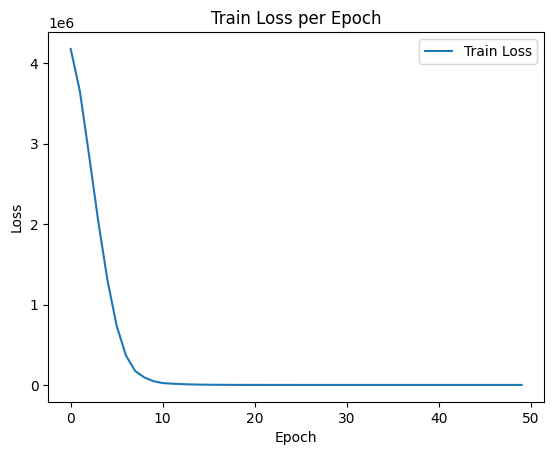

In [33]:
plt.plot(losses_mlp, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss per Epoch')
plt.show()

In [34]:
encoder_with_mlp.eval()

EncoderWithMLP(
  (encoder): Sequential(
    (0): Linear(in_features=11, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=5, bias=True)
    (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=5, out_features=3, bias=True)
  )
  (mlp): Sequential(
    (0): Linear(in_features=3, out_features=2, bias=True)
    (1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [36]:
result1 = encoder_with_mlp(encoder_mlp_train_df)

In [37]:
result1[:10]

tensor([[82.6126],
        [82.6130],
        [82.6127],
        [82.6127],
        [82.6127],
        [82.6126],
        [82.6124],
        [82.6130],
        [82.6128],
        [82.6127]], grad_fn=<SliceBackward0>)

In [38]:
y_train[:10]

tensor([83.4245, 79.3741, 82.1816, 83.0066, 83.0514, 85.7061, 90.6092, 84.6352,
        80.9786, 82.3696])

In [39]:
encoder_with_mlp.mlp.training

False

In [40]:
testset = testset.float()

In [41]:
test_result = encoder_with_mlp(testset)

In [42]:
test_result[:10]

tensor([[82.6127],
        [82.6128],
        [82.6124],
        [82.6125],
        [82.6127],
        [82.6127],
        [82.6127],
        [82.6127],
        [82.6124],
        [82.6127]], grad_fn=<SliceBackward0>)

In [43]:
test_result_np = test_result.detach().numpy()

# NumPy 배열을 pandas DataFrame으로 변환
test_result_pd = pd.DataFrame(test_result_np)

# 결과 출력
print(len(test_result_pd))

4986


In [44]:
sample_submission_csv_path = os.path.join(
    ROOT_DIR, 
    'dataset', 
    'sample_submission.csv'
)

submission_csv_path = os.path.join(
    ROOT_DIR, 
    'dataset', 
    'submission.csv'
)

submission = pd.read_csv(sample_submission_csv_path)
submission['y'] = test_result_pd
submission.to_csv(submission_csv_path, index=False)